In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')

tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import random
import time
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

True


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Input data stream

In [3]:
input_params = data = pd.read_table('input_data/condition.txt', header = None)

datasetNo = int(input_params.values[5,2])
n_epochs = int(input_params.values[16,2])
Lv1_latent_dim = int(input_params.values[13,2])

num_param = int(input_params.values[1,2])
num_time = int(input_params.values[2,2])
num_node = int(input_params.values[3,2])
num_var = int(input_params.values[4,2])

print('num_param : ', num_param)
print('num_time : ', num_time)
print('num_node : ', num_node)
print('num_var : ', num_var)
print(' ')
print('datasetNo : ', datasetNo)
print('Lv1_epochs_to_read : ', n_epochs)
print('Lv1_latent_dim : ', Lv1_latent_dim)

num_param :  10
num_time :  800
num_node :  14300
num_var :  1
 
datasetNo :  2
Lv1_epochs_to_read :  1000
Lv1_latent_dim :  128


In [4]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


## FOM data type : FOM_data = np.array[time, param, node, var]

In [5]:
FOM_data = np.zeros((num_time, num_param, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[l,k,j,i]=data[i,j,temp]
                
FOM_data.shape

(800, 10, 14300, 1)

## Scale data to [0, 1]

In [6]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

print(maximum)
print(minimum)
print(mean)
print(AT)

1.98040931309693
-2.50954989641887
1.361459507680192e-18
4.4899592095158


In [7]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
min_FOM = np.min(FOM_data)
FOM_data = FOM_data-min_FOM

print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


# Level 1, SCAE (spatial CAE)

In [8]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [9]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

Lv1_input_shape = Lv1_input.shape[1:]

print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


# Acquire latent vectors

In [10]:
Lv1_input.shape

(8000, 14300, 1)

In [11]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

epoch = n_epochs
filename1='Lv1_networks/encoder_%d.h5' % (epoch)
filename2='Lv1_networks/decoder_%d.h5' % (epoch)
Encoder = load_model(filename1)
Encoder.summary()
tf.keras.utils.plot_model(Encoder, show_shapes=True)
Decoder = load_model(filename2)
Decoder.summary()
tf.keras.utils.plot_model(Decoder, show_shapes=True)
temp_lv1 = np.zeros([1,Lv1_input.shape[1],Lv1_input.shape[2]])
Lv1_latent = np.zeros([num_time, num_param, Lv1_latent_dim])

for i in range(num_time):
    for j in range(num_param):
        k = i*num_param+j
        temp_lv1[0,:,:] = Lv1_input[k,:,:]
        
        temp3= Encoder(temp_lv1, training=False) # Encoder output shape : mu, sigma, latent_vector = Encoder(x_train, training=False)
        
        Lv1_latent[i,j,:] = np.asarray(temp3)[0,:]
        
        # Lv1_latent [param, time, latent] -> reduced spatial dimension to latent dimension.

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14300, 64)         384       
_________________________________________________________________
batch_normalization (BatchNo (None, 14300, 64)         256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14300, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14300, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14300, 128)        41088     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14300, 128)        512 

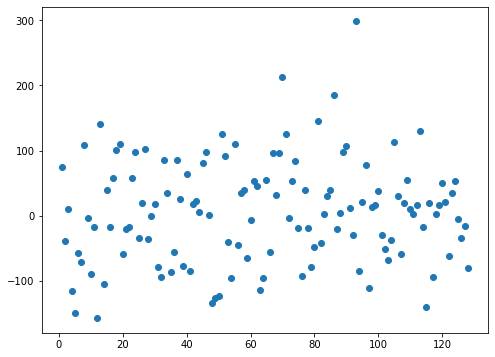

In [12]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

plt.scatter(x_axis1, Lv1_latent[0,2,:])

# Examine accuracy of CAE

In [13]:
to_plot = np.zeros([num_time, num_param, num_node,num_var])

for j in range(num_time):
    for i in range(num_param):
        #print(j)
        temp4 = Lv1_latent[j,i,:]
        
        temp4 = np.reshape(temp4, [-1, Lv1_latent_dim])
        EX = Decoder(temp4)
        to_plot[j,i,:,:] = EX[0,:,:]

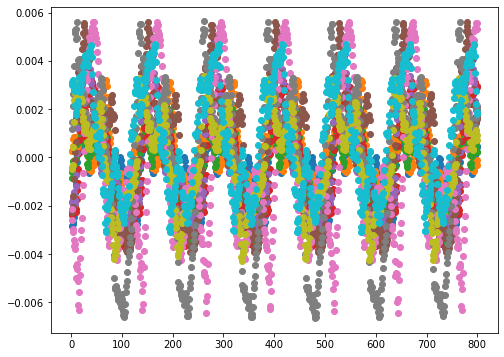

In [14]:
x_axis3 = np.linspace(1,num_time,num_time)

for i in range(num_param):
    plt.scatter(x_axis3, to_plot[:, i,0,0]-FOM_data[:,i,0,0])

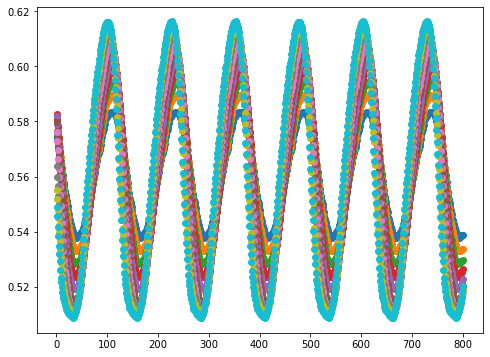

In [15]:
for i in range(num_param):
    plt.scatter(x_axis3, to_plot[:,i,0,0])

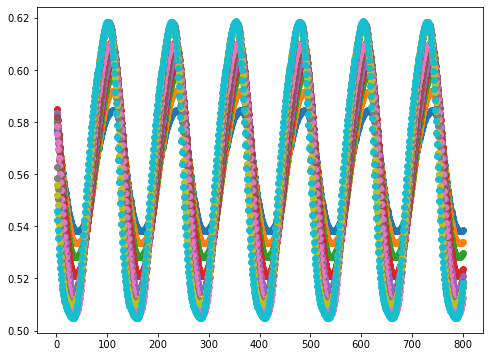

In [16]:
for i in range(num_param):
    plt.scatter(x_axis3, FOM_data[:,i,0,0])

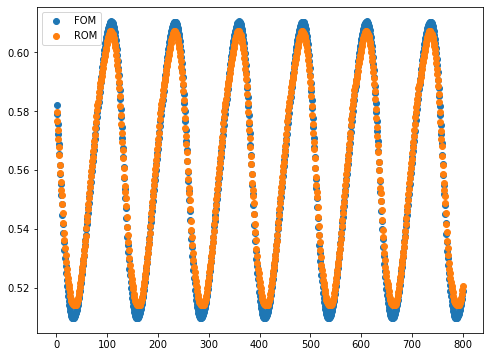

In [17]:
plt.scatter(x_axis3, FOM_data[:,5,0,0], label='FOM')
plt.scatter(x_axis3, to_plot[:,5,0,0], label='ROM')
plt.legend()

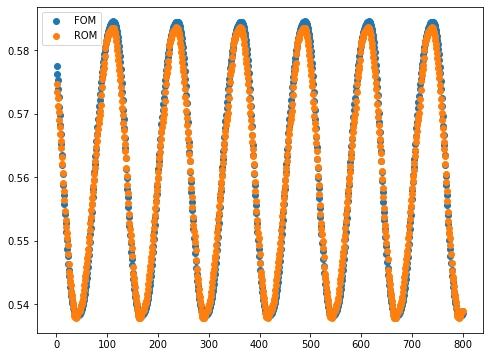

In [18]:
plt.scatter(x_axis3, FOM_data[:,0,0,0], label='FOM')
plt.scatter(x_axis3, to_plot[:,0,0,0], label='ROM')
plt.legend()

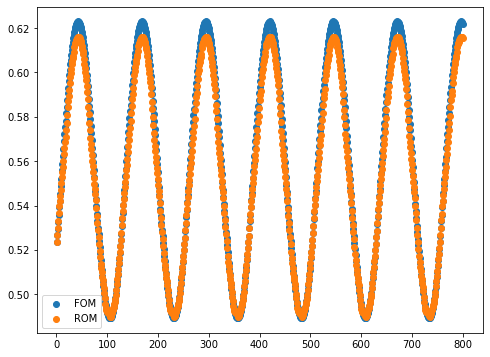

In [19]:
plt.scatter(x_axis3, FOM_data[:,1,14299,0], label='FOM')
plt.scatter(x_axis3, to_plot[:,1,14299,0], label='ROM')
plt.legend()

# Reconstruction : time+parameter at a certain node point

In [20]:
Lv1_input.shape

(8000, 14300, 1)

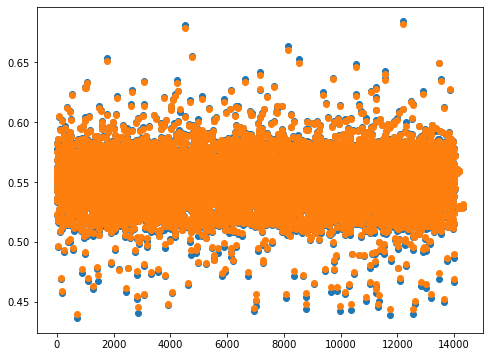

In [21]:
temp = np.zeros([1,num_node,num_var])

temp[0,:,:] = Lv1_input[0,:,:]

temp2 = Encoder(temp)
temp3 = Decoder(temp2)

x_axis = np.linspace(0,num_node,num_node)

plt.scatter(x_axis, temp[0,:,0])
plt.scatter(x_axis, temp3[0,:,0])

In [22]:
Lv1_latent = np.swapaxes(Lv1_latent, 0, 1)
print(Lv1_latent.shape)

(10, 800, 128)


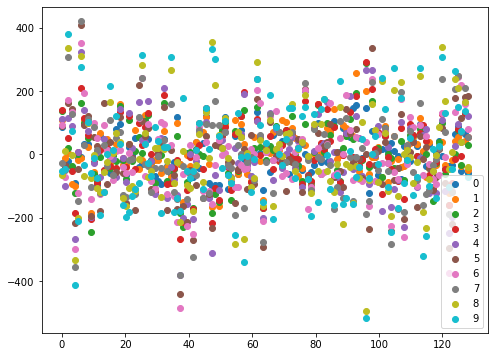

In [23]:
x_axis_ = np.linspace(0,Lv1_latent_dim,Lv1_latent_dim)

for i in range(num_param):
    plt.scatter(x_axis_, Lv1_latent[i,5,:], label = i)
    
plt.legend()

# Output latent vectors to file

In [24]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'Lv1_latent_vectors/latent_vector_p-s%d_batchnorm' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

In [25]:
del Encoder
del Decoder

In [26]:
pause;

NameError: name 'pause' is not defined

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.